# Analyzing European Parliament Votes 

Zarnescu Dragos Ioan 331 AB

- In this project, I propose to analyze different voting patterns of MEPs on resolutions disscused this year. To view votting patterns of members throughtout their party and independent and also to build a classifier to predict MEPs party.

- Steps of the project

1. Getting The Data
    - As the data was public throught the organization's site, https://www.europarl.europa.eu/plenary/en/votes.html?tab=votes   , i could find easily the xml file where on a given date there were all resolutions discussed and the MEPs votes.
    - Gathering this data I parsed the xml file into a csv where i had all MEPs with their vote on the given resolution into a csv.
    - The data received consists in 720 MEPs and 480 ammendments voted with 4 types of vote possible ( For, Against, Abstention, Did Not Vote).

2. Understanding the data 
    - Ploted the data to get a better understanding of how votes are distributed into the parliament

3. Group the data in clusters
    - By how they voted For or Against and by How active they were
    - By Each MEPs votes
    - By Each Party's votes
    - On this step we standardize the data to have the data for each party according to their number of votes
    - We reduce the data with PCA in order to find the directions that best describe the variance in the high dimensional data.
        - First PCA Component captures the direction of maximum variance showing the "largest" difference or trend across all MEPs voting behaviors. It rsepresents the primary ideological divide. For instance, it might capture whether a politician's votes are more aligned with being "For" or "Against" 
        
        - Second PCA Component captures the second-most significant variation. The interpretation of PC2 in this case depends on the variation in voting behavior across the politicians in your dataset. PC2 will capture the variance between those who vote actively and those who tend to abstain or be absent more frequently.

4. Creating a Model to predict MEPs party by their voting behaviour
    - for this step we are going to use the 50 with most variance PCA components
    - we are going to implement a RandomForestClassifier :
        - It combines multiple decision trees to make predictions, which typically improves performance and reduces overfitting compared to a single decision tree.
        - The process involves training multiple decision trees on random subsets of the data and combining their predictions through majority voting .
        It uses :
        - Decision Trees: Each tree learns to predict a party affiliation based on features voting behavior.
        - Ensemble Method: The Random Forest builds many decision trees and aggregates their outputs to make the final prediction.
        - Random Subsets of Data: Each tree is trained on a random subset of the data, and at each split, only a random subset of features is considered to split on.

In [197]:
import xml.etree.ElementTree as ET
import pandas as pd
import os

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder



In [199]:


folder_path = "european_parliament"
votes_csv_path = "wide_votes_data.csv"

# Data structures for storing results
wide_data = {}
members_set = set()

# Loop through all XML files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".xml"):
        file_path = os.path.join(folder_path, file_name)

        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Process each roll-call vote to extract resolutions and votes
        for vote_result in root.findall(".//RollCallVote.Result"):
            resolution_id = vote_result.get("Identifier")
            resolution_description = vote_result.find(".//RollCallVote.Description.Text").text

            for vote_type, tag_name in [("For", "Result.For"),("For","Intentions.Result.For"), ("Against", "Result.Against"),("Against","Intentions.Result.Against"), ("Abstention", "Result.Abstention")]:
                for group in vote_result.findall(f".//{tag_name}/Result.PoliticalGroup.List"):
                    group_identifier = group.get("Identifier")

                    for member in group.findall(".//PoliticalGroup.Member.Name"):
                        member_name = member.text
                        member_id = member.get("PersId")

                        # Add to members set (to remove duplicates later)
                        members_set.add((member_id, member_name, group_identifier))

                        # Initialize member's record in wide_data if not already present
                        if member_name not in wide_data:
                            wide_data[member_name] = {"id": member_id, "party": group_identifier}

                        # Add the vote for the current resolution
                        wide_data[member_name][resolution_description] = vote_type

# Ensure all members have entries for all resolutions, if it is missing it meand It did not vote
all_resolutions = set()
for member_data in wide_data.values():
    all_resolutions.update(member_data.keys())

for member_name, data in wide_data.items():
    for resolution in all_resolutions:
        if resolution not in data:
            data[resolution] = "Did Not Vote"

# Convert wide_data dictionary to DataFrame
wide_data_df = pd.DataFrame.from_dict(wide_data, orient="index").reset_index()
wide_data_df.rename(columns={"index": "full_name"}, inplace=True)

wide_data_df.drop_duplicates(subset="id", keep="first", inplace=True)
wide_data_df.sort_values("full_name", inplace=True)

# Save both DataFrames to CSV files
wide_data_df.to_csv(votes_csv_path, index=False)



(721, 480)


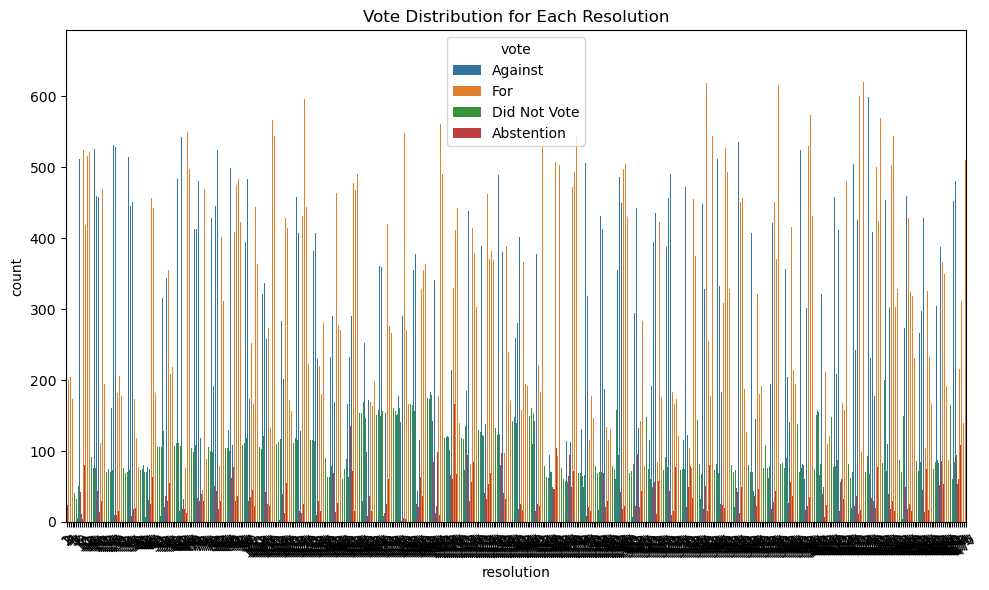

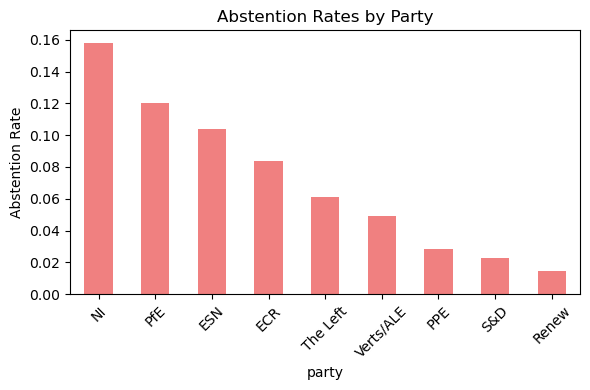

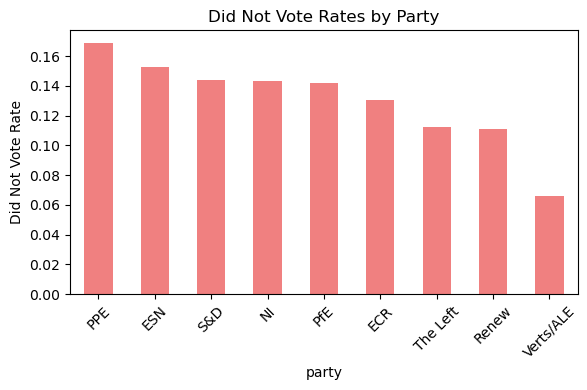

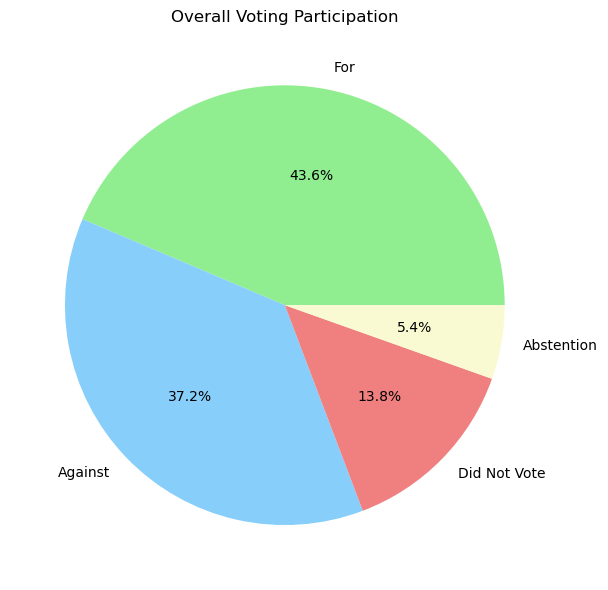

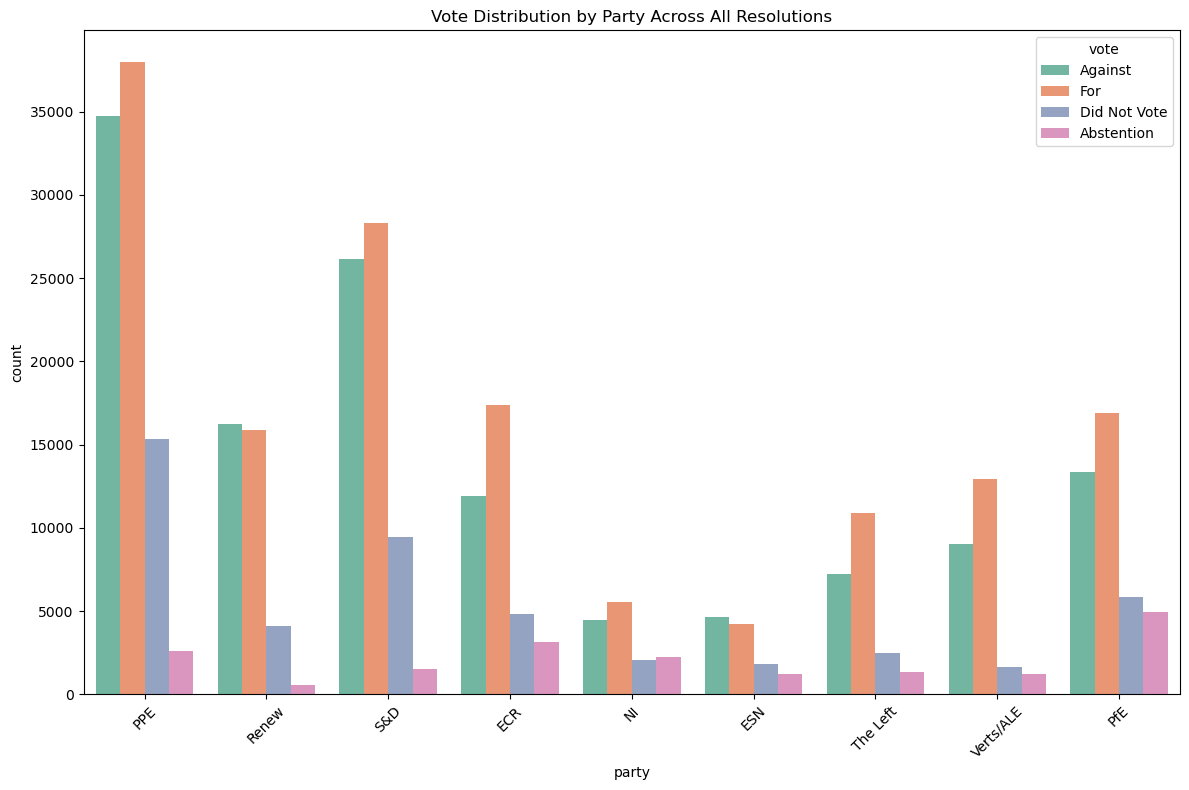

In [200]:
data = pd.read_csv('wide_votes_data.csv')
print(data.shape)
# Melt the data to make it easier to analyze
melted_data = data.melt(id_vars=['full_name', 'id', 'party'], 
                        value_vars=[col for col in data.columns if col not in ['full_name', 'id', 'party']],
                        var_name='resolution', value_name='vote')

# Assign an index (1, 2, 3, ...) to each resolution
resolution_names = melted_data['resolution'].unique()
resolution_index_map = {name: str(i+1) for i, name in enumerate(resolution_names)}
melted_data['resolution'] = melted_data['resolution'].map(resolution_index_map)

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot vote distribution for each resolution
sns.countplot(data=melted_data, x='resolution', hue='vote')
plt.title('Vote Distribution for Each Resolution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calculate rates by party
def plot_rates(melted_data, vote):
    rates = melted_data[melted_data['vote'] == vote]
    vote_rate = rates.groupby('party')['vote'].count() / melted_data.groupby('party')['vote'].count()

    plt.figure(figsize=(6, 4))
    vote_rate.sort_values(ascending=False).plot(kind='bar', color='lightcoral')
    plt.title(f'{vote} Rates by Party')
    plt.ylabel(f'{vote} Rate')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_rates(melted_data, 'Abstention')
plot_rates(melted_data, 'Did Not Vote')

# Calculate overall voting participation (including 'Did not vote', 'Abstention', etc.)
voting_participation = melted_data['vote'].value_counts(normalize=True) * 100

# Plot overall voting participation
plt.figure(figsize=(8, 6))
voting_participation.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightskyblue', 'lightcoral', 'lightgoldenrodyellow'])
plt.title('Overall Voting Participation')
plt.ylabel('')  # Remove y-axis label
plt.tight_layout()
plt.show()


# Plot vote distribution for each party
plt.figure(figsize=(12, 8))
sns.countplot(data=melted_data, x='party', hue='vote', palette='Set2')
plt.title('Vote Distribution by Party Across All Resolutions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [201]:
# Preprocessing
# Extract relevant columns for clustering
vote_columns = data.columns[3:]  
party_column = data['party']  

# Map votes to numerical values without encoding
vote_mapping = {"For": 3, "Against": 2, "Abstention": 1, "Did Not Vote": 0}
data_votes = data[vote_columns].replace(vote_mapping)

#Preprocessing data for clustering
scaler = StandardScaler()
X_scaled_politicians = scaler.fit_transform(data_votes)

party_grouped = data_votes.groupby(party_column).mean()
X_scaled_parties = scaler.fit_transform(party_grouped)

/tmp/ipykernel_522650/2289830171.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_votes = data[vote_columns].replace(vote_mapping)


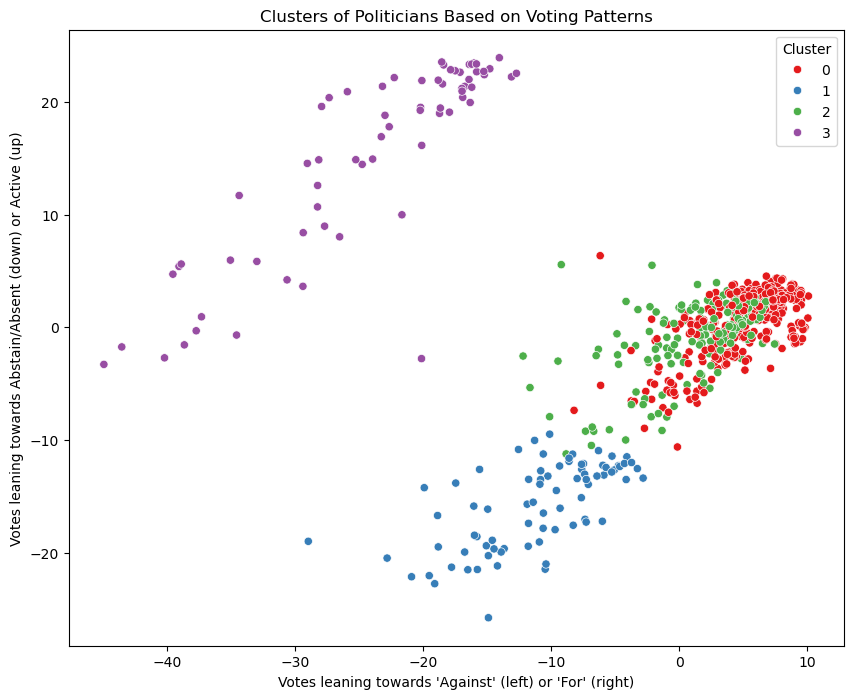

In [198]:
kmeans_politicians = KMeans(n_clusters=4, random_state=42)
politician_clusters = kmeans_politicians.fit_predict(X_scaled_politicians)

# Visualize Clusters: Politicians
pca = PCA(n_components=2)
X_pca_politicians = pca.fit_transform(X_scaled_politicians)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_politicians[:, 0], y=X_pca_politicians[:, 1], hue=politician_clusters, palette="Set1")
plt.title("Clusters of Politicians Based on Voting Patterns")
plt.xlabel("Votes leaning towards 'Against' (left) or 'For' (right)")
plt.ylabel("Votes leaning towards Abstain/Absent (down) or Active (up)")
plt.legend(title="Cluster")
plt.show()

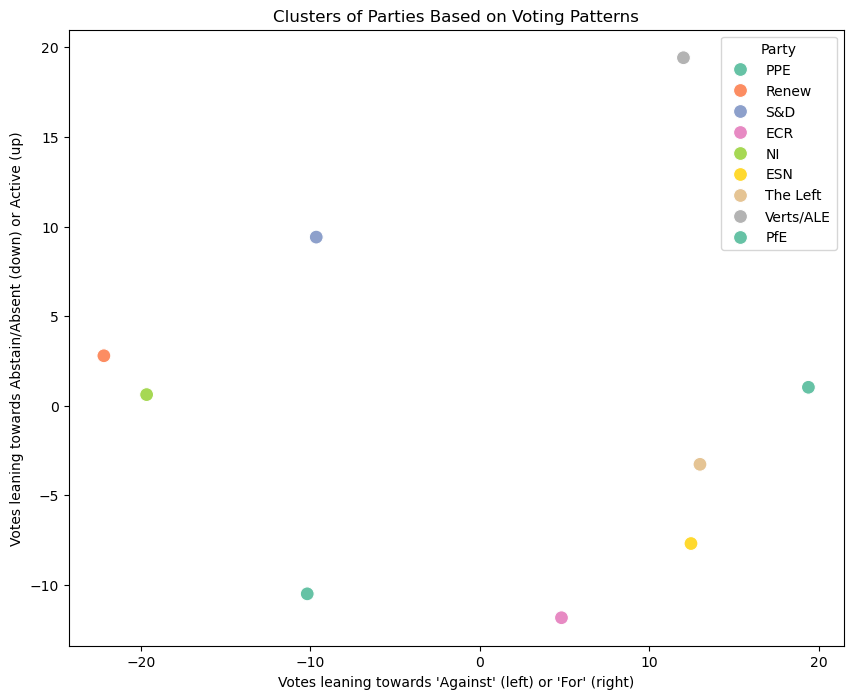

In [202]:
kmeans_parties = KMeans(n_clusters=9, random_state=42)
party_clusters = kmeans_parties.fit_predict(X_scaled_parties)

X_pca_parties = pca.fit_transform(X_scaled_parties)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca_parties[:, 0], 
    y=X_pca_parties[:, 1], 
    hue=party_column.unique(), 
    palette="Set2", 
    s=100
)

plt.title("Clusters of Parties Based on Voting Patterns")
plt.xlabel("Votes leaning towards 'Against' (left) or 'For' (right)")
plt.ylabel("Votes leaning towards Abstain/Absent (down) or Active (up)")
plt.legend(title="Party")
plt.show()


In [203]:




vote_columns = data.columns[3:]  
politicians_to_test = ["Iovanovici Şoşoacă", "Bogdan", "Ştefănuță", "Negrescu", "Barna", "Târziu"]

# Step 3: Encode votes into numeric form
label_encoder = LabelEncoder()
vote_data = data[vote_columns].apply(lambda col: label_encoder.fit_transform(col))
vote_data['full_name'] = data['full_name']
vote_data['party'] = data['party']  

# Step 4: Ensure test politicians are in the test set
test_data = vote_data[vote_data['full_name'].isin(politicians_to_test)]
remaining_data = vote_data[~vote_data['full_name'].isin(politicians_to_test)]

# Split the remaining data into training and testing sets
train_data, additional_test_data = train_test_split(
    remaining_data, test_size=0.3, random_state=42
)

final_test_data = pd.concat([test_data, additional_test_data])

# Separate features and labels
X_train = train_data.drop(columns=['full_name', 'party'])
X_test = final_test_data.drop(columns=['full_name', 'party'])
y_train = train_data['party']
y_test = final_test_data['party']

# Step 5: Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Step 6: Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_reduced, y_train)

# Step 7: Predict party affiliation for the test data
y_pred = clf.predict(X_test_reduced)

# Step 8: Calculate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

print("Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Step 9: Display predictions for specific politicians
print("Predicted vs Actual Parties for Specified Politicians:")
for politician in politicians_to_test:
    actual_party = final_test_data.loc[final_test_data['full_name'] == politician, 'party'].values[0]
    predicted_party = clf.predict(pca.transform(X_test.loc[final_test_data['full_name'] == politician]))[0]
    print(f"{politician}: Predicted = {predicted_party}, Actual = {actual_party}")



Overall Accuracy: 0.95
Detailed Classification Report:
              precision    recall  f1-score   support

         ECR       1.00      0.97      0.98        31
         ESN       0.71      1.00      0.83         5
          NI       1.00      0.25      0.40         8
         PPE       0.97      1.00      0.98        60
         PfE       0.88      0.97      0.92        30
       Renew       1.00      1.00      1.00        15
         S&D       0.93      0.97      0.95        39
    The Left       0.94      0.94      0.94        16
   Verts/ALE       1.00      0.88      0.94        17

    accuracy                           0.95       221
   macro avg       0.94      0.89      0.88       221
weighted avg       0.95      0.95      0.94       221

Predicted vs Actual Parties for Specified Politicians:
Iovanovici Şoşoacă: Predicted = PfE, Actual = NI
Bogdan: Predicted = PPE, Actual = PPE
Ştefănuță: Predicted = S&D, Actual = Verts/ALE
Negrescu: Predicted = S&D, Actual = S&D
Barna: Pred